## A/B Test analysis on E-commerce website Data


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

C:\Users\darwi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1')['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
n1 = len(df.query('landing_page=="new_page"').query('group=="control"'))
n1

1928

In [7]:
n2 = len(df.query('landing_page=="old_page"').query('group=="treatment"'))
n2

1965

In [8]:
n1 + n2

3893

f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = df.drop(df.query('landing_page=="new_page"').query('group=="control"').index) 

In [11]:
df2 = df2.drop(df.query('landing_page=="old_page"').query('group=="treatment"').index) 

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
len(df2)

290585

In [15]:
df2['user_id'].value_counts().index[0]

773192

c. What is the row information for the repeat **user_id**? 

In [16]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2 = df2.drop(df2.query('user_id == 773192').index[0])

In [18]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
df2.query('group=="treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
len(df2.query('landing_page=="new_page"'))/len(df2)

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Your answer goes here.**

In [23]:
prob_converted = df2['converted'].mean()

prob_newPage = len(df2.query('landing_page=="new_page"'))/len(df2)

prob_oldPage = 1 - prob_newPage

prob_converted_GivenNewPage = df2.query('group=="treatment"')['converted'].mean()

prob_converted_GivenOldPage = df2.query('group=="control"')['converted'].mean()

In [24]:
prob_oldPage_GivenConverted = prob_converted_GivenOldPage * prob_oldPage / prob_converted
prob_oldPage_GivenConverted

0.5032371306074297

In [25]:
prob_NewPage_GivenConverted = prob_converted_GivenNewPage * prob_newPage / prob_converted
prob_NewPage_GivenConverted

0.49676286939257047

As prob_oldPage_GivenConverted and prob_NewPage_GivenConverted is so close to each other, I do not think there is evidence that one page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$H_0$: **$p_{new}$** - **$p_{old}$**  $ = 0$

$H_1$: **$p_{new}$** - **$p_{old}$**  $\neq 0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [26]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [27]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [28]:
n_new = df2.query('landing_page=="new_page"').shape[0]
n_new 

145310

d. What is $n_{old}$?

In [29]:
n_old = df2.query('landing_page=="old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [30]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [31]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [32]:
new_page_converted.mean() - old_page_converted.mean()

0.0014570322354333087

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [33]:
new_page_CR_simulate = np.random.binomial(n=n_new, p=p_new, size=10000)/n_new

old_page_CR_simulate = np.random.binomial(n=n_old, p=p_old, size=10000)/n_old

p_diffs = new_page_CR_simulate - old_page_CR_simulate

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

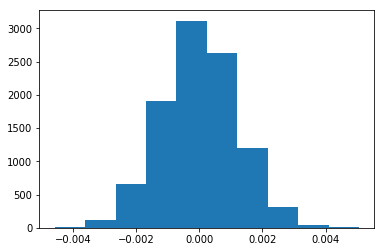

In [36]:
plt.hist(p_diffs);

According to the Central Limit Theorem, sampling distribution of this **p_diffs** will be normally distributed if sample size is large enough. Here, we use a sample size for each page equal to the ones in **ab_data**, which should be large enough. As we expected, the **p_diffs** follows Gaussian distribution. In addition, we are simulating the **p_diffs** under the Null hypothesis that there is no difference between new page and old page regarding to conversion rate, as a result this histogram is centered at zero. Based on the these, this histogram plot is in line with my expectation. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
p_diff_actual = df2.query('landing_page=="new_page"')['converted'].mean() - df2.query('landing_page=="old_page"')['converted'].mean()
p_diff_actual

-0.0015782389853555567

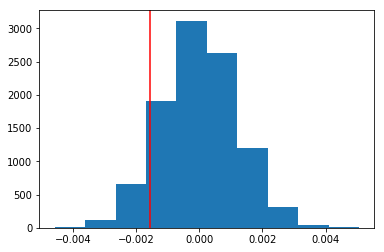

In [38]:
plt.hist(p_diffs);
plt.axvline(x=p_diff_actual, color='r');

The red line shows where the observed statistic falls. The actual $p_{new}$ - $p_{old}$ observered in **ab_data** is -0.00158  . 

In [39]:
(p_diffs > p_diff_actual).mean()

0.90720000000000001

About 91% of the **p_diffs** are greater than the actual difference observed in **ab_data**.

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

In part **j.** we calculate the proportion of simulated $p_{new}$ - $p_{old}$ values which are greater than the actual observed difference. Such proportion is the probability of observing all the Null values that are more extreme than the observed statistic in **ab_data** in favor of the alternative hypothesis, if the null hypothesis is true. The test for part **j.** is one tail, and here, we are using Null hypothese of $p_{new}$ - $p_{old}$ $<=0$, and alternative hypothesis of $p_{new}$ - $p_{old}$ $>0$ .

The proportion calculated in part **j.** is called p-value in the scientific studies. p-value of 0.907 is much greater than the Type I error rate of 0.05, therefore, we fail to reject the null hypothesis. As a result, we suggest that the new page is no better than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
convert_old = df2.query('landing_page=="old_page"').query('converted==1').shape[0]
convert_new = df2.query('landing_page=="new_page"').query('converted==1').shape[0]
n_old = df2.query('landing_page=="old_page"').shape[0]
n_new = df2.query('landing_page=="new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

If it is a one-tail test, and the alternative hypothesis is $p_{new}$ - $p_{old}$ $>0$ :

In [41]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

If it is a two-tail test, and the alternative hypothesis is **$p_{new}$** - **$p_{old}$**  $\neq 0$ :

In [42]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='two-sided')
z_score, p_value

(-1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

z-score suggest how far the observed statistic is away from the mean of **p_diffs** in terms of the standard deviation of **p_diffs**. As we can see the observed statistic is 1.31 times of standard deviation away from the mean, in addition, the p-value of 0.905 is much larger than 0.05. As a result, we fail to reject the Null hypothesis and we suggest that the new page is no better than the old page regarding to the conversion rate. These findings agree with those in parts **j.** and **k.**.  

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

I should perform Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
dummies = pd.get_dummies(df2['group'])
dummies.head()

,control,treatment
0,1,0
1,1,0
2,0,1
3,0,1
4,1,0


In [44]:
df2['intercept'] = 1

In [45]:
df2['ab_page'] = dummies['treatment']

In [46]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [47]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:52:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

The p-value associated with **ab_page** is 0.19 . It is different from the p-value found in the **Part II**, which is 0.905, because they are using different Null hypothesises.

In **Part III**, the test is two-tail and 

$H_0$: **$p_{new}$** - **$p_{old}$**  $ = 0$

$H_1$: **$p_{new}$** - **$p_{old}$**  $\neq 0$           .

While in **Part II**, the test is one-tail, and 

$H_0$: **$p_{new}$** - **$p_{old}$**  $ <= 0$

$H_1$: **$p_{new}$** - **$p_{old}$**  $ > 0$  .  

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

It is a good idea to incorporate other factors in the the regression model because more information and more angles may lead to a more complete picture, and thus lead to a more accurate prediction. However, it would be worth noting that adding additional terms may introduce the problem of multicollinearity, which happens when some predictor variables are correlated with one another.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [49]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [50]:
df2 = df2.join(countries.set_index('user_id'), on='user_id', how='left')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [51]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
dtypes: int64(3), object(4), uint8(1)
memory usage: 18.0+ MB


In [52]:
dummies_country = pd.get_dummies(df2['country'])
dummies_country.head()

,CA,UK,US
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [53]:
df2['US'] = dummies_country['US']
df2['UK'] = dummies_country['UK']

In [54]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,1,0


In [55]:
logit_mod2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'UK']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 15 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        12:56:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

The p-values associated with country are all larger than 0.05, which suggest the country do not have significant impact on conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [56]:
df2['ab_page_US'] = df2['ab_page']*df2['US']
df2['ab_page_UK'] = df2['ab_page']*df2['UK']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,ab_page_US,ab_page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,1,0,0,0


In [57]:
logit_mod3 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'US', 'UK', 'ab_page_US', 'ab_page_UK']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Aug 2018   Pseudo R-squ.:               3.482e-05
Time:                        12:57:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_page_US     0.0469      0.054      0.872      0.383      -0.059       0.152
ab_page_UK     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

The interaction between page and country have no significant effects on conversion as their p-values are all larger than 0.05 .

<a id='conclusions'></a>
## Conclusions

> Based on the above analysis in **part III**, we find that there is not enough evidence showing one page is better than the other regarding to the conversion rate. In other words, there is no significant difference between the old page and the new page. In addition, country in which a user lives do not show impact on the conversion. 

> For the next step, it's good to run hypothesis test on a longer period until one page is consistently significantly better than the other for a certain amount of time. Moreover, update and imporvement are needed in order to make the new page more influential and attractive.

## Resources

https://www.khanacademy.org/math/statistics-probability/significance-tests-one-sample/more-significance-testing-videos/v/hypothesis-testing-and-p-values

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])